<a href="https://colab.research.google.com/github/DT6A/Hands-On_Machine_Learning/blob/main/ML14_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PCA with Undercomplite Linear Autoencoder

In [ ]:
import tensorflow as tf

tf.reset_default_graph()

n_inputs = 3 # 3D inputs
n_hidden = 2 # 2D coding
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [ ]:
import numpy as np
from sklearn.datasets import make_regression

data, _ = make_regression(150, 3, 2, )

X_train = data[:100]
X_test = data[100:]

n_iterations = 1000
codings = hidden # output of the hidden layer

with tf.Session() as sess:
  init.run()
  for iteration in range(n_iterations):
    training_op.run(feed_dict={X: X_train})
    if iteration % 100 == 0:
      mse = reconstruction_loss.eval(feed_dict={X: X_train})
      print(iteration, 'MSE:', mse)
    
  codings_val = codings.eval(feed_dict={X: X_test})

0 MSE: 1.3194445
100 MSE: 0.36611477
200 MSE: 0.3648909
300 MSE: 0.36246395
400 MSE: 0.35462525
500 MSE: 0.32096386
600 MSE: 0.28225768
700 MSE: 0.28050604
800 MSE: 0.28049293
900 MSE: 0.28049284


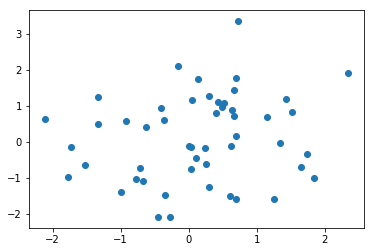

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(codings_val[:, 0], codings_val[:, 1])

## Stacked Autoencoders

In [ ]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('/tmp/data/')

W0715 14:34:02.174998 140559443765120 deprecation.py:323] From <ipython-input-107-cfd3bd6057da>:3: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0715 14:34:02.176608 140559443765120 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0715 14:34:02.178205 140559443765120 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:252: _internal_retry.<locals>.wrap.<locals>.wrapped_fn (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be remov

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz


W0715 14:34:02.563957 140559443765120 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0715 14:34:02.646950 140559443765120 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [ ]:
from functools import partial

tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.initializers.he_normal()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense = partial(tf.layers.dense,
                  activation=tf.nn.elu,
                  kernel_initializer=he_init,
                  kernel_regularizer=l2_regularizer)

hidden1 = my_dense(X, n_hidden1)
hidden2 = my_dense(hidden1, n_hidden2)
hidden3 = my_dense(hidden2, n_hidden3)
outputs = my_dense(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [ ]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    n_batches = mnist.train.num_examples // batch_size
    for iteration in range(n_batches):
      X_batch, y_batch = mnist.train.next_batch(batch_size)
      sess.run(training_op, feed_dict={X: X_batch})
    ls = sess.run(loss, feed_dict={X: mnist.test.images})  
    print(epoch, 'Loss:', ls)

0 Loss: 0.08405751
1 Loss: 0.038587183
2 Loss: 0.027454244
3 Loss: 0.0239999
4 Loss: 0.023008198


### Tying weights

In [ ]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

activation = tf.nn.elu
he_init = tf.initializers.he_normal()
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

weights1_init = he_init([n_inputs, n_hidden1])
weights2_init = he_init([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name='weights1')
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name='weights2')
weights3 = tf.Variable(weights2, name='weights3') # tied
weights4 = tf.Variable(weights1, name='weights4') # tied

biases1 = tf.Variable(tf.zeros(n_hidden1), name='biases1')
biases2 = tf.Variable(tf.zeros(n_hidden2), name='biases2')
biases3 = tf.Variable(tf.zeros(n_hidden3), name='biases3')
biases4 = tf.Variable(tf.zeros(n_outputs), name='biases4')

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, tf.transpose(weights3)) + biases3)
outputs = tf.matmul(hidden3, tf.transpose(weights4)) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_losses = regularizer(weights1) + regularizer(weights2)

loss = reconstruction_loss + reg_losses

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [ ]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    n_batches = mnist.train.num_examples // batch_size
    for iteration in range(n_batches):
      X_batch, y_batch = mnist.train.next_batch(batch_size)
      sess.run(training_op, feed_dict={X: X_batch})
    ls = sess.run(loss, feed_dict={X: mnist.test.images})  
    print(epoch, 'Loss:', ls)

0 Loss: 0.04674118
1 Loss: 0.028876532
2 Loss: 0.3887431
3 Loss: 0.28892756
4 Loss: 0.24161847


### Training one Autoencoder at a time

In [ ]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

activation = tf.nn.elu
he_init = tf.initializers.he_normal()
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

weights1_init = he_init([n_inputs, n_hidden1])
weights2_init = he_init([n_hidden1, n_hidden2])
weights3_init = he_init([n_hidden2, n_hidden3])
weights4_init = he_init([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name='weights1')
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name='weights2')
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name='weights3') 
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name='weights4') 

biases1 = tf.Variable(tf.zeros(n_hidden1), name='biases1')
biases2 = tf.Variable(tf.zeros(n_hidden2), name='biases2')
biases3 = tf.Variable(tf.zeros(n_hidden3), name='biases3')
biases4 = tf.Variable(tf.zeros(n_outputs), name='biases4')

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4


optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope('phase1'):
  phase1_outputs = tf.matmul(hidden1, weights4) + biases4
  phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
  phase1_reg_losses = regularizer(weights1) + regularizer(weights4)
  phase1_loss = phase1_reconstruction_loss + phase1_reg_losses
  phase1_training_op = optimizer.minimize(phase1_loss)
  
with tf.name_scope('phase2'):
  phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
  phase2_reg_losses = regularizer(weights2) + regularizer(weights3)
  phase2_loss = phase2_reconstruction_loss + phase2_reg_losses
  train_vars = [weights2, weights3, biases2, biases3]
  phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars)
  
init = tf.global_variables_initializer()

In [ ]:
n_test_digits = 5
X_test = mnist.test.images[:n_test_digits]

In [ ]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    n_batches = mnist.train.num_examples // batch_size
    for iteration in range(n_batches):
      X_batch, y_batch = mnist.train.next_batch(batch_size)
      sess.run(phase1_training_op, feed_dict={X: X_batch})
    ls = sess.run(phase1_loss, feed_dict={X: mnist.test.images})  
    print(epoch, 'Loss:', ls)
    
  for epoch in range(n_epochs):
    n_batches = mnist.train.num_examples // batch_size
    for iteration in range(n_batches):
      X_batch, y_batch = mnist.train.next_batch(batch_size)
      sess.run(phase2_training_op, feed_dict={X: X_batch})
    ls = sess.run(phase2_loss, feed_dict={X: mnist.test.images})  
    print(epoch, 'Loss:', ls)
    
  outputs_val = outputs.eval(feed_dict={X: X_test})  
  weights1_val = weights1.eval()
  

0 Loss: 0.017811934
1 Loss: 0.015250219
2 Loss: 0.015284633
3 Loss: 0.015430549
4 Loss: 0.015578742
0 Loss: 0.13144822
1 Loss: 0.018858962
2 Loss: 0.0115811
3 Loss: 0.010106068
4 Loss: 0.009684999


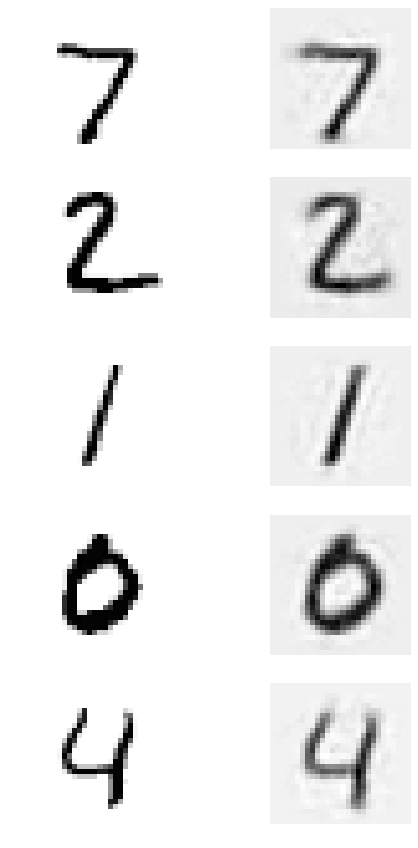

In [ ]:
import matplotlib.pyplot as plt

def plot_image(image, shape=[28, 28]):
  plt.imshow(image.reshape(shape), cmap='Greys', interpolation='nearest')
  plt.axis('off')
  
  
fig = plt.figure(figsize=(8, 3 * n_test_digits))

for idx in range(n_test_digits):
  plt.subplot(n_test_digits, 2, idx * 2 + 1)
  plot_image(X_test[idx])
  plt.subplot(n_test_digits, 2, idx * 2 + 2)
  plot_image(outputs_val[idx])

### Visualizing features

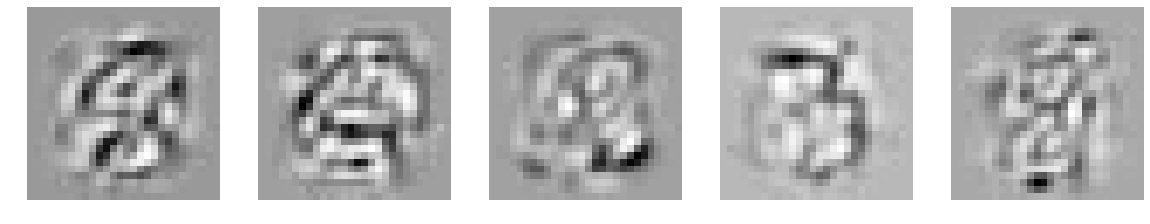

In [ ]:
fig = plt.figure(figsize=(20, 10 * 5))
for i in range(5):
  plt.subplot(1, 5, i + 1)
  plot_image(weights1_val.T[i])

## Denoising Autoencoders

In [ ]:
tf.reset_default_graph()

noise_level = 1.0

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

activation = tf.nn.elu
he_init = tf.initializers.he_normal()
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

weights1_init = he_init([n_inputs, n_hidden1])
weights2_init = he_init([n_hidden1, n_hidden2])
weights3_init = he_init([n_hidden2, n_hidden3])
weights4_init = he_init([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name='weights1')
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name='weights2')
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name='weights3') 
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name='weights4') 

biases1 = tf.Variable(tf.zeros(n_hidden1), name='biases1')
biases2 = tf.Variable(tf.zeros(n_hidden2), name='biases2')
biases3 = tf.Variable(tf.zeros(n_hidden3), name='biases3')
biases4 = tf.Variable(tf.zeros(n_outputs), name='biases4')

hidden1 = activation(tf.matmul(X_noisy, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4


optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope('phase1'):
  phase1_outputs = tf.matmul(hidden1, weights4) + biases4
  phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
  phase1_reg_losses = regularizer(weights1) + regularizer(weights4)
  phase1_loss = phase1_reconstruction_loss + phase1_reg_losses
  phase1_training_op = optimizer.minimize(phase1_loss)
  
with tf.name_scope('phase2'):
  phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
  phase2_reg_losses = regularizer(weights2) + regularizer(weights3)
  phase2_loss = phase2_reconstruction_loss + phase2_reg_losses
  train_vars = [weights2, weights3, biases2, biases3]
  phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars)
  
init = tf.global_variables_initializer()

In [ ]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    n_batches = mnist.train.num_examples // batch_size
    for iteration in range(n_batches):
      X_batch, y_batch = mnist.train.next_batch(batch_size)
      sess.run(phase1_training_op, feed_dict={X: X_batch})
    ls = sess.run(phase1_loss, feed_dict={X: mnist.test.images})  
    print(epoch, 'Loss:', ls)
    
  for epoch in range(n_epochs):
    n_batches = mnist.train.num_examples // batch_size
    for iteration in range(n_batches):
      X_batch, y_batch = mnist.train.next_batch(batch_size)
      sess.run(phase2_training_op, feed_dict={X: X_batch})
    ls = sess.run(phase2_loss, feed_dict={X: mnist.test.images})  
    print(epoch, 'Loss:', ls)
    
  outputs_val = outputs.eval(feed_dict={X: X_test})  
  X_n = X_noisy.eval(feed_dict={X: X_test})
  

0 Loss: 0.04869065
1 Loss: 0.041794818
2 Loss: 0.0426487
3 Loss: 0.043635417
4 Loss: 0.045203447
0 Loss: 1.1072121
1 Loss: 1.007698
2 Loss: 0.0615239
3 Loss: 0.049922213
4 Loss: 0.045015868


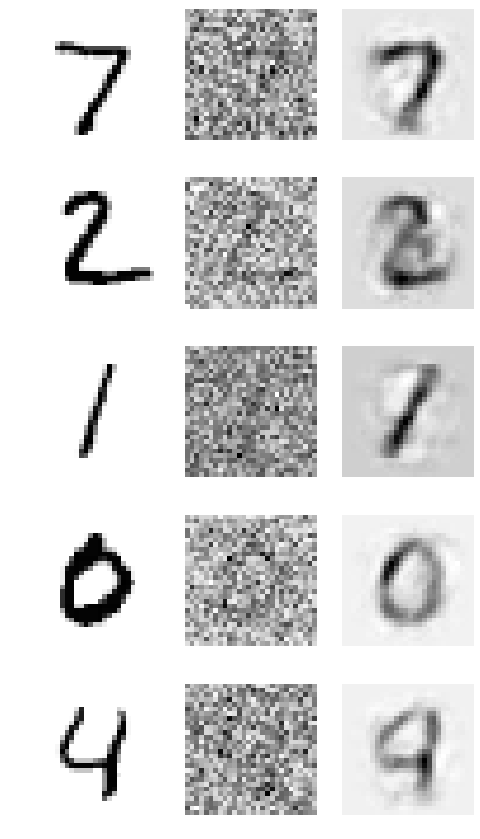

In [ ]:
import matplotlib.pyplot as plt

def plot_image(image, shape=[28, 28]):
  plt.imshow(image.reshape(shape), cmap='Greys', interpolation='nearest')
  plt.axis('off')
  
  
fig = plt.figure(figsize=(8, 3 * n_test_digits))

for idx in range(n_test_digits):
  plt.subplot(n_test_digits, 3, idx * 3 + 1)
  plot_image(X_test[idx])
  plt.subplot(n_test_digits, 3, idx * 3 + 2)
  plot_image(X_n[idx])
  plt.subplot(n_test_digits, 3, idx * 3 + 3)
  plot_image(outputs_val[idx])

## Sparse Autoencoders

In [ ]:
def kl_divergence(p, q):
  return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.initializers.he_normal()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense = partial(tf.layers.dense,
                  activation=tf.nn.elu,
                  kernel_initializer=he_init,
                  kernel_regularizer=l2_regularizer)

hidden1 = my_dense(X, n_hidden1)
hidden2 = my_dense(hidden1, n_hidden2, activation=tf.nn.sigmoid)
hidden3 = my_dense(hidden2, n_hidden3)
logits = my_dense(hidden3, n_outputs, activation=None)
outputs = tf.nn.sigmoid(logits)

hidden2_mean = tf.reduce_mean(hidden2, axis=0)
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden2_mean))

xentr = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_mean(xentr)

loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [ ]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    n_batches = mnist.train.num_examples // batch_size
    for iteration in range(n_batches):
      X_batch, y_batch = mnist.train.next_batch(batch_size)
      sess.run(training_op, feed_dict={X: X_batch})
    ls = sess.run(loss, feed_dict={X: mnist.test.images})  
    print(epoch, 'Loss:', ls)
  outputs_val = outputs.eval(feed_dict={X: X_test})  

0 Loss: 0.24729688
1 Loss: 0.22087747
2 Loss: 0.1963162
3 Loss: 0.20372528
4 Loss: 0.16056663


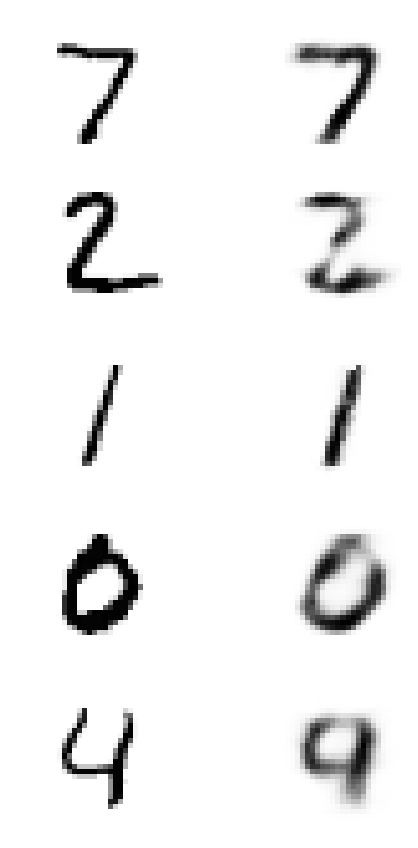

In [ ]:
import matplotlib.pyplot as plt

def plot_image(image, shape=[28, 28]):
  plt.imshow(image.reshape(shape), cmap='Greys', interpolation='nearest')
  plt.axis('off')
  
  
fig = plt.figure(figsize=(8, 3 * n_test_digits))

for idx in range(n_test_digits):
  plt.subplot(n_test_digits, 2, idx * 2 + 1)
  plot_image(X_test[idx])
  plt.subplot(n_test_digits, 2, idx * 2 + 2)
  plot_image(outputs_val[idx])

##Variational Autoencoders

In [ ]:
tf.reset_default_graph()

n_inputs = 28*28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.0005

initializer = tf.initializers.he_normal()

my_dense_layer = partial(
  tf.layers.dense,
  activation=tf.nn.elu,
  kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentr = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentr)
latent_loss = 0.5 * tf.reduce_sum(
  tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
n_digits = 60
n_epochs = 500
batch_size = 150

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    n_batches = mnist.train.num_examples // batch_size
    for iteration in range(n_batches):
      X_batch, y_batch = mnist.train.next_batch(batch_size)
      sess.run(training_op, feed_dict={X: X_batch})
    
    if epoch % 50 == 0:
      ls = sess.run(loss, feed_dict={X: mnist.test.images})  
      print(epoch, 'Loss:', ls) 
      
  codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
  outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 Loss: 1264347.9
50 Loss: 995164.9
100 Loss: 977241.4
150 Loss: 970376.4
200 Loss: 963928.5
250 Loss: 960885.6
300 Loss: 959893.7
350 Loss: 957114.1
400 Loss: 957974.25
450 Loss: 957112.06


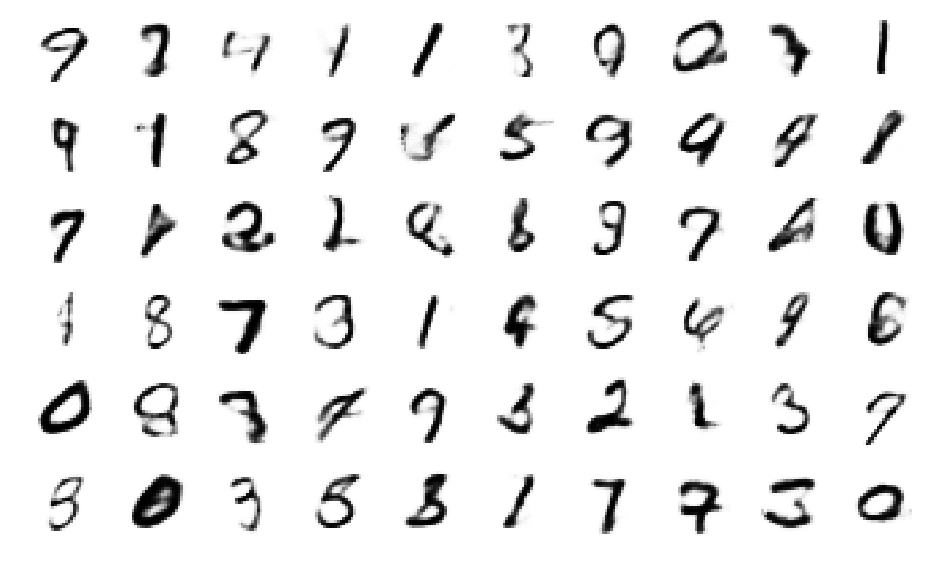

In [ ]:
plt.figure(figsize=(16,100)) 

for iteration in range(n_digits):
  plt.subplot(n_digits, 10, iteration+1)
  plot_image(outputs_val[iteration])

##Exercises

###8

In [ ]:
from keras.datasets import cifar10

from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


170500096/170498071 [==============================] - 6s 0us/step


In [ ]:
X_train = X_train.reshape(-1, 32 * 32 * 3) / 255
X_test = X_test.reshape(-1, 32 * 32 * 3) / 255

In [ ]:
tf.reset_default_graph()

n_inputs = 32 * 32 * 3
n_hidden1 = 1500
n_hidden2 = 800
n_hidden3 = 400
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs

l2_reg = 0.0001

learning_rate = 0.0001

noise_scale = 0.3

X = tf.placeholder(tf.float32, [None, n_inputs])
X_noisy = X + noise_scale * tf.random_normal(tf.shape(X))

dense = partial(tf.layers.dense,
               activation=tf.nn.elu,
               kernel_initializer=tf.initializers.he_normal(),
               kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))

hidden1 = dense(X_noisy, n_hidden1)
hidden2 = dense(hidden1, n_hidden2)
hidden3 = dense(hidden2, n_hidden3)
hidden4 = dense(hidden3, n_hidden4)
hidden5 = dense(hidden4, n_hidden5)
logits = dense(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - logits))
reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

loss = tf.add_n([reconstruction_loss] + reg_loss)

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.95,
                                       use_nesterov=True)#tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

y = tf.placeholder(tf.int32, [None])

n_outputs_clf = 10
clf_logits = dense(hidden3, n_outputs_clf, activation=None)
clf_outputs = tf.sigmoid(clf_logits)

xentr = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=clf_logits)
clf_loss = tf.reduce_mean(xentr)

clf_optimizer = tf.train.AdamOptimizer(0.01)

clf_training_op = clf_optimizer.minimize(clf_loss, var_list=[tf.trainable_variables()[-1], tf.trainable_variables()[-2]])

correct = tf.nn.in_top_k(clf_logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [ ]:
n_test_digits = 5
X_check = X_test[10:15]

In [ ]:
class cifar10:
  class train:
    def next_batch(batch_size):
      idx = np.random.choice(np.arange(0, len(X_train)), batch_size)
      return X_train[idx], y_train[idx].reshape(-1)
  class test:
    def next_batch(batch_size):
      idx = np.random.choice(np.arange(0, len(X_test)), batch_size)
      return X_test[idx], y_test[idx].reshape(-1)

In [ ]:
import matplotlib.pyplot as plt

def plot_cifar(image, shape=[32, 32, 3]):
  plt.imshow(image.reshape(shape), interpolation='nearest')
  plt.axis('off')

0 Loss: 1.4666854
5 Loss: 1.1259398
10 Loss: 0.9856416
15 Loss: 0.9101473
20 Loss: 0.86988866
25 Loss: 0.8488186
30 Loss: 0.8376349
35 Loss: 0.8309426
40 Loss: 0.82661873
45 Loss: 0.8234379
50 Loss: 0.8210585
55 Loss: 0.81915474
60 Loss: 0.81757075
65 Loss: 0.8161722
70 Loss: 0.8149208
75 Loss: 0.8138373
80 Loss: 0.81279886
85 Loss: 0.8118453
90 Loss: 0.8109023
95 Loss: 0.81012154
100 Loss: 0.80930364
105 Loss: 0.8085829
110 Loss: 0.80784994
115 Loss: 0.80720896
120 Loss: 0.80649745
125 Loss: 0.80591244
130 Loss: 0.80526584
135 Loss: 0.80471265
140 Loss: 0.8041606
145 Loss: 0.80358744
150 Loss: 0.80301344
155 Loss: 0.802479
160 Loss: 0.8019595
165 Loss: 0.8014518
170 Loss: 0.80093634
175 Loss: 0.8004465
180 Loss: 0.7999841
185 Loss: 0.79946136
190 Loss: 0.7990314
195 Loss: 0.7985399


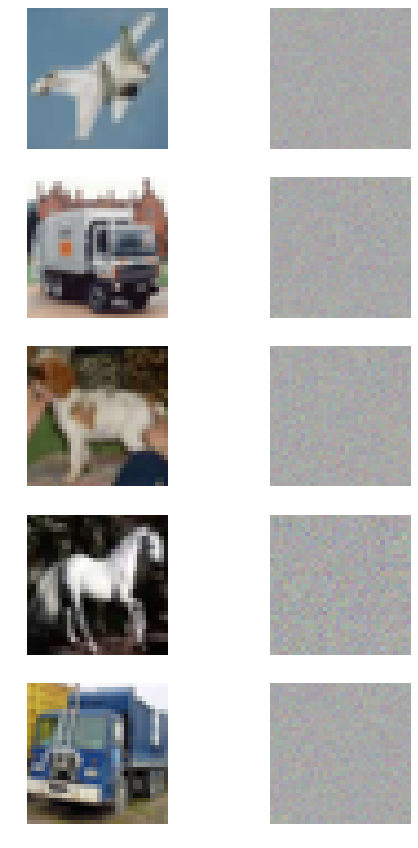

0 Loss: 2.4455862 Accuracy: 0.10152
10 Loss: 2.3008926 Accuracy: 0.13016
20 Loss: 2.4402666 Accuracy: 0.132
30 Loss: 2.3355923 Accuracy: 0.14292
40 Loss: 2.3185685 Accuracy: 0.15018


KeyboardInterrupt: ignored

In [ ]:
n_epochs = 200
batch_size = 250

n_epochs_clf = 150

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    for iteration in range(len(X_train) // batch_size):
      X_batch, _ = cifar10.train.next_batch(batch_size)
      sess.run(training_op, feed_dict={X: X_batch})
    if epoch % 5 == 0:  
      ls = sess.run(loss, feed_dict={X: X_test})
      print(epoch, 'Loss:', ls)  
  
  X_rec = sess.run(outputs, feed_dict={X: X_check})
  fig = plt.figure(figsize=(8, 3 * n_test_digits))

  for idx in range(n_test_digits):
    plt.subplot(n_test_digits, 2, idx * 2 + 1)
    plot_cifar(X_check[idx])
    plt.subplot(n_test_digits, 2, idx * 2 + 2)
    plot_cifar(X_rec[idx])
  plt.show()
  
  for epoch in range(n_epochs_clf):
    for iteration in range(len(X_test) // batch_size):
      X_batch, y_batch = cifar10.test.next_batch(batch_size)
      sess.run(clf_training_op, feed_dict={X: X_batch, y: y_batch})
    if epoch % 10 == 0:
      ls, acc = sess.run([clf_loss, accuracy], feed_dict={X: X_train, 
                                                 y: y_train.reshape(-1)})
      print(epoch, 'Loss:', ls, 'Accuracy:', acc)

In [ ]:
import tensorflow as tf
import numpy as np
from functools import partial

In [ ]:
tf.reset_default_graph()

n_inputs = 32 * 32 * 3
n_hidden1 = 1500
n_hidden2 = 800
n_hidden3 = 400
n_outputs_clf = 10


learning_rate = 0.01

X = tf.placeholder(tf.float32, [None, n_inputs])
y = tf.placeholder(tf.int32, [None])

dense = partial(tf.layers.dense,
               activation=tf.nn.elu,
               kernel_initializer=tf.initializers.he_normal())

hidden1 = dense(X, n_hidden1)
hidden2 = dense(hidden1, n_hidden2)
hidden3 = dense(hidden2, n_hidden3)
clf_logits = dense(hidden3, n_outputs_clf, activation=None)
clf_outputs = tf.sigmoid(clf_logits)

optimizer = tf.train.AdamOptimizer(learning_rate)

xentr = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=clf_logits)
clf_loss = tf.reduce_mean(xentr)

clf_training_op = optimizer.minimize(clf_loss)

correct = tf.nn.in_top_k(clf_logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

W0715 09:01:51.505739 140559443765120 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:

batch_size = 150

n_epochs_clf = 250

with tf.Session() as sess:
  init.run()
  
  for epoch in range(n_epochs_clf):
    for iteration in range(len(X_test) // batch_size):
      X_batch, y_batch = cifar10.test.next_batch(batch_size)
      sess.run(clf_training_op, feed_dict={X: X_batch, y: y_batch.reshape(-1)})
    if epoch % 10 == 0:
      ls, acc = sess.run([clf_loss, accuracy], feed_dict={X: X_train, 
                                                 y: y_train.reshape(-1)})
      print(epoch, 'Loss:', ls, 'Accuracy:', acc)

0 Loss: 2.254858 Accuracy: 0.16572
10 Loss: 1.8751899 Accuracy: 0.3159
20 Loss: 1.8743894 Accuracy: 0.33602
30 Loss: 1.7383381 Accuracy: 0.37626
40 Loss: 1.7612085 Accuracy: 0.40284
50 Loss: 1.7804139 Accuracy: 0.40502
60 Loss: 1.8902103 Accuracy: 0.37694
70 Loss: 1.9371158 Accuracy: 0.35054
80 Loss: 1.8579551 Accuracy: 0.40304
90 Loss: 2.0819843 Accuracy: 0.399
100 Loss: 2.0401232 Accuracy: 0.39332
110 Loss: 2.267813 Accuracy: 0.36436
120 Loss: 2.244458 Accuracy: 0.36506
130 Loss: 2.3628883 Accuracy: 0.38618
140 Loss: 2.1662774 Accuracy: 0.38826
150 Loss: 2.4801207 Accuracy: 0.39544
160 Loss: 2.7641332 Accuracy: 0.35494


KeyboardInterrupt: ignored

In [ ]:
mnist.validation.num_examples

5000

###9

In [ ]:
tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 30
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.001

noise_rate = 0.70

X = tf.placeholder(tf.float32, [None, n_inputs])
training = tf.placeholder_with_default(0.0, [])

dense = partial(tf.layers.dense,
               activation=tf.nn.elu,
               kernel_initializer = tf.initializers.he_normal())

hidden1 = dense(X, n_hidden1)
hidden1_noisy = hidden1 + noise_rate * training * tf.random_normal(tf.shape(hidden1))
hidden2 = dense(hidden1_noisy, n_hidden2, activation=tf.nn.sigmoid)
hidden3 = dense(hidden2, n_hidden3)
logits = dense(hidden3, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [ ]:
n_epochs = 100
batch_size = 150


with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    for iteration in range(len(X_train) // batch_size):
      X_batch, _ = mnist.train.next_batch(batch_size)
      sess.run(training_op, feed_dict={X: X_batch, training: 1.0})
    if epoch % 10 == 0:
      ls = sess.run(loss, feed_dict={X: mnist.test.images})
      print(epoch, 'Loss:', ls)
  hashes = sess.run(hidden2, feed_dict={X: mnist.test.images})  

0 Loss: 1158411.8
10 Loss: 725504.06
20 Loss: 686913.75
30 Loss: 667425.7
40 Loss: 659727.4
50 Loss: 651305.94
60 Loss: 642089.75
70 Loss: 637617.25
80 Loss: 634564.9
90 Loss: 631084.06


In [ ]:
hashes[36]

array([0.50416756, 0.6579157 , 0.50246394, 0.13143134, 0.18181631,
       0.50532776, 0.44491073, 0.15511596, 0.22179103, 0.13712612,
       0.69505835, 0.50419575, 0.7715975 , 0.64792943, 0.6970533 ,
       0.83369756, 0.493577  , 0.83993196, 0.872607  , 0.42536893,
       0.7088436 , 0.29346216, 0.8029381 , 0.6858143 , 0.42157948,
       0.26717487, 0.16121292, 0.6352573 , 0.62955046, 0.20896211],
      dtype=float32)

In [ ]:
rounded = hashes >= 0.5

In [ ]:
rounded = rounded.astype(np.int)

In [ ]:
rounded[1000]

array([0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1])

True

In [ ]:
def GetScore(src, target, ind):
  n = 0
  eq = 0
  for i in range(len(rounded)):
    if i != ind:
      if np.sum(src == rounded[i]) >= 27:
        if mnist.test.labels[i] == target:
          eq += 1
        n += 1
  if n != 0:      
    return eq / n
  else:
    return 0

In [ ]:
scores = []
for i in range(len(hashes)):
  scores.append(GetScore(rounded[i], mnist.test.labels[i], i))  

(array([2468.,   10.,   42.,   50.,   28.,  229.,  139.,  145.,  280.,
        6609.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

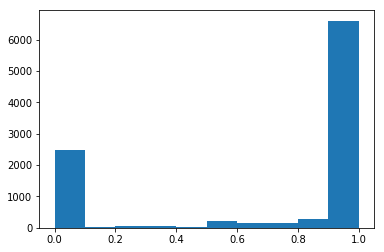

In [ ]:
plt.hist(scores)

In [ ]:
scores

In [ ]:
print(hashes[:10])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1.]]


In [ ]:
print(hashes[2000:2010])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1.]]


### 10

In [ ]:
tf.reset_default_graph()

shape_conv1 = (5, 5)
n_filt1 = 4
shape_conv2 = (3, 3)
n_filt2 = 8
shape_conv3 = (1, 1)
n_filt3 = 16
shape_conv4 = shape_conv3
n_filt4 = filt3
shape_conv5 = shape_conv2
n_filt5 = filt2
shape_conv6 = shape_conv1
n_filt6 = filt1

X = tf.placeholder(tf.float32, [None, 28, 28, 1])
X_noisy = X + 0.1 * tf.random_normal(tf.shape(X))

loss_mul = tf.placeholder(tf.float32, 1)

learning_rate = 0.001

convolution = partial(tf.layers.conv2d, 
                     activation=tf.nn.elu,
                     padding='SAME',
                     kernel_initializer=tf.initializers.he_normal(),
                     strides=(2, 2))
deconvolution = partial(tf.layers.conv2d_transpose, 
                     activation=tf.nn.elu,
                     padding='SAME',
                     kernel_initializer=tf.initializers.he_normal(),
                     strides=(2, 2))

conv1 = convolution(X, n_filt1, shape_conv1)
conv2 = convolution(conv1, n_filt2, shape_conv2)

conv3_mean = convolution(conv2, n_filt3, shape_conv3, strides=1, activation=None)
conv3_gamma = convolution(conv2, n_filt3, shape_conv3, strides=1, activation=None)
noise = tf.random_normal(tf.shape(conv3_gamma), dtype=tf.float32)
conv3 = conv3_mean + tf.exp(0.5 * conv3_gamma) * noise

deconv4 = deconvolution(tf.reshape(conv3, (-1, 7, 7, n_filt3)), n_filt5, shape_conv4, strides=1)
deconv5 = deconvolution(deconv4, n_filt6, shape_conv5)
logits = deconvolution(deconv5, 1, shape_conv6, activation=None)
outputs = tf.sigmoid(logits)

rec_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X))
latent_loss = 0.5 * tf.reduce_sum(
  tf.exp(conv3_gamma) + tf.square(conv3_mean) - 1 - conv3_gamma)

loss = rec_loss + 5 * latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [ ]:
X_test = mnist.test.images[:5]

In [ ]:
n_epochs = 100
batch_size = 150
n_digits = 60

mul = 0.0003

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    for iteration in range(mnist.train.num_examples // batch_size):
      X_batch, _ = mnist.train.next_batch(batch_size)
      sess.run(training_op, feed_dict={X: X_batch.reshape(-1, 28, 28, 1), loss_mul: [mul]})
      
    if epoch % 20 == 0:
      ls = sess.run(loss, feed_dict={X: mnist.test.images.reshape(-1, 28, 28, 1), loss_mul: [mul]})
      print(epoch, 'Loss:', ls)
    mul += 0.0003
  reconstr = sess.run(outputs, feed_dict={X: X_test.reshape(-1, 28, 28, 1), loss_mul: [mul]})    
  codings_rnd = np.random.normal(size=[n_digits, 7, 7, 16])
  outputs_val = outputs.eval(feed_dict={conv3: codings_rnd})

0 Loss: 3086225.5
20 Loss: 2357176.8
40 Loss: 2353331.8
60 Loss: 2351361.5
80 Loss: 2348396.5


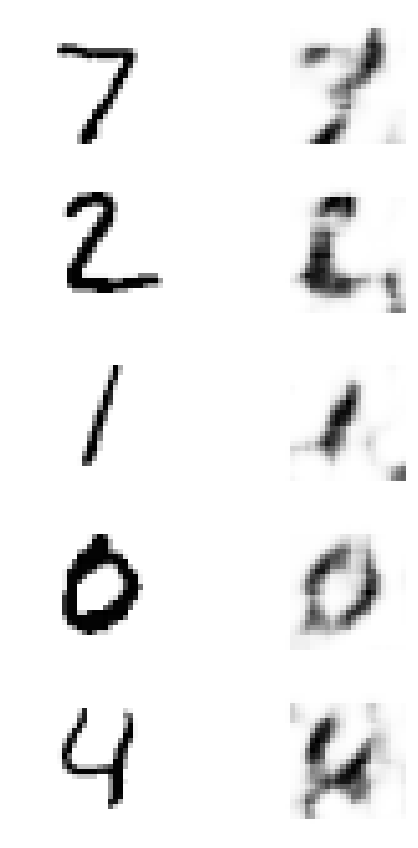

In [ ]:
import matplotlib.pyplot as plt

def plot_image(image, shape=[28, 28]):

  plt.imshow(image.reshape(shape), cmap='Greys', interpolation='nearest')
  plt.axis('off')
  
n_test_digits = 5
  
fig = plt.figure(figsize=(8, 3 * n_test_digits))

for idx in range(n_test_digits):
  plt.subplot(n_test_digits, 2, idx * 2 + 1)
  plot_image(X_test[idx])
  plt.subplot(n_test_digits, 2, idx * 2 + 2)
  plot_image(reconstr[idx])

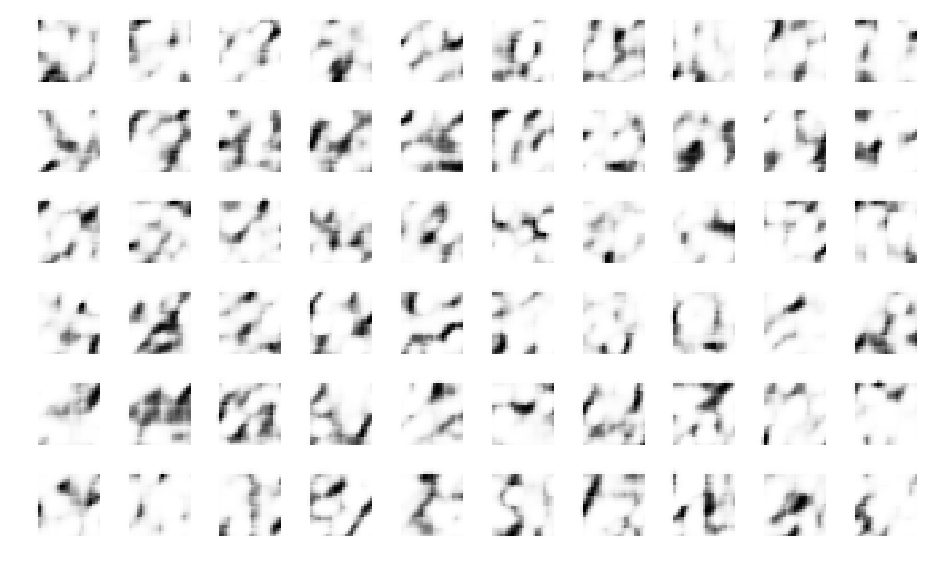

In [ ]:
plt.figure(figsize=(16,100)) 

for iteration in range(n_digits):
  plt.subplot(n_digits, 10, iteration+1)
  plot_image(outputs_val[iteration])